In [2]:
import pandas as pd
import datetime
import numpy
import sqlite3
from datetime import date
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
### Database ###
conn = sqlite3.connect("Tweets.db")
c = conn.cursor()

In [ ]:
# pd.set_option('display.max_columns', None)

# Check top 100 Hashtags

### (all set to lowercase)


In [ ]:
# get hashtags from entities column
hashtags = {}
sqlQuery = "SELECT * FROM Tweet Order BY created_at ASC"
df = pd.read_sql_query(sqlQuery, conn)
df['created_at'] = df['created_at'].str.split('T', 0, expand=True)
df.created_at = pd.to_datetime(df.created_at)
df = df.set_index("created_at")
dftmp = df
for index, row in dftmp.iterrows():
#     print(index)
    if row['entities']:
        if "'hashtags':" in row['entities']:
            entities = ast.literal_eval(row['entities'])
#             print(entities)
            for hashtag in entities['hashtags']:
                hashtag_lower = hashtag['tag'].lower()
                if hashtag_lower in hashtags:
                    hashtags[hashtag_lower] += 1
                else:
                    hashtags[hashtag_lower] = 1

# print(hashtags)
            

In [ ]:
#visualize top 50 hashtags

import numpy as np
import matplotlib.pyplot as plt

#sort dict
s_hashtags = {k: v for k, v in sorted(hashtags.items(), key=lambda item: item[1], reverse=True)}
s_hashtags_list = list(s_hashtags.items())

for i in range(0,10):
    print(i+1, ":\t",s_hashtags_list[i][1],  "\t", s_hashtags_list[i][0],)

# Check for bots
### (users with more than 150 tweets per day)

In [ ]:
# checks for users with tweet count > 150 / day
sqlQuery = "SELECT * FROM Tweet Order BY created_at ASC"
df = pd.read_sql_query(sqlQuery, conn)
df['created_at'] = df['created_at'].str.split('T', 0, expand=True)
df.created_at = pd.to_datetime(df.created_at)
df = df.set_index("created_at")

In [ ]:
# checks for users with tweet count > 150 / day
sqlQuery = "SELECT * FROM User Order BY created_at ASC"
df = pd.read_sql_query(sqlQuery, conn)
df['created_at'] = df['created_at'].str.split('T', 0, expand=True)
df.created_at = pd.to_datetime(df.created_at)
df = df.set_index("created_at")


bots = []
endtime = pd.Timestamp('2020-06-30')
for index, row in df.iterrows():
    delta = endtime - index
    if delta.days == 0:
        continue
    if row['tweet_count'] / delta.days > 150:
#         print("bot  detected: ", row['tweet_count'] / delta.days,  row['name'], row['username'])
        bots.append((row['user_id'], round(row['tweet_count'] / delta.days,2), row['name'], row['username']))

bots.sort(key= lambda x: x[1], reverse=True)
print("Number of bots found: ", len(bots))

In [ ]:
# top 20 detected bots who posted most tweets in general (not only AI related)
for i in range(0,20):
    print(i+1, ": ", bots[i])

In [ ]:
# get the total number of tweets from bots in the dataset
bots2 = []
totalTweets = 0
with conn:
    for b in bots:
        nrtweets =  c.execute("""SELECT count(*) FROM Tweet WHERE author_id = '%s' """ % b[0]).fetchone() 
        bots2.append((b[2],b[3],nrtweets[0]))
        totalTweets += nrtweets[0]

bots2.sort(key= lambda x: x[2], reverse=True)
        
print("Total number of tweets from bots in dataset: ", totalTweets)

In [ ]:
# top 20 detected bots with most tweets in dataset (posted about AI topics)
for i in range(0,20):
    print(i+1, ": ", bots2[i])

## Check users with most tweets in data set

In [ ]:
# print users with most tweets
with conn:
    nrtweetsByUser = c.execute("""SELECT tweetcount, name 
FROM User, 
(SELECT author_id, count(author_id) as tweetcount FROM Tweet GROUP BY author_ID ORDER BY tweetcount DESC) 
WHERE User.user_id = author_id""").fetchall()

# for u in range(0,10):
#     print(nrtweetsByUser[u])

In [12]:
nrtweetsByUser2 = [] 
for d in nrtweetsByUser:
    nrtweetsByUser2.append(d[0])

In [ ]:
# with conn:
#     tnofTweets = c.execute("SELECT count(*) FROM Tweet").fetchone()[0]
#     tnofUsers = c.execute("SELECT count(*) FROM User").fetchone()[0]
#     nrtweetsByUser = c.execute("""SELECT tweetcount, name 
# FROM User, 
# (SELECT author_id, count(author_id) as tweetcount FROM Tweet GROUP BY author_ID ORDER BY tweetcount DESC) 
# WHERE User.user_id = author_id""").fetchall()
    
# totalTweetsOFTop01Percent = 0
# totalTweetsOFTop1Percent = 0
# totalTweetsOFTop10Percent = 0

# percent01 = int(0.001*tnofUsers)
# percent1 = int(0.01*tnofUsers)
# percent10 = int(0.1*tnofUsers)
# for u in nrtweetsByUser[0:percent01]:
#     totalTweetsOFTop01Percent += u[0]
# for u in nrtweetsByUser[0:percent1]:
#     totalTweetsOFTop1Percent += u[0]
# for u in nrtweetsByUser[:percent10]:
#     totalTweetsOFTop10Percent += u[0]

# print("Top 0.1% of all Users account for :", round(totalTweetsOFTop01Percent /tnofTweets,2)*100, "% of all Tweets")
# print("Top 1% of all Users account for :", round(totalTweetsOFTop1Percent /tnofTweets,1)*100, "% of all Tweets")
# print("Top 10% of all Users account for :", round(totalTweetsOFTop10Percent /tnofTweets,2)*100, "% of all Tweets")

In [ ]:
usersWithOneTweet = 0
for u in nrtweetsByUser:
    if u[0] == 1:
        usersWithOneTweet += 1

print(usersWithOneTweet/tnofTweets)   

## Visualize Content

In [4]:
# group tweets tweets by year get count
# visualize count for each year

sqlQuery = "SELECT * FROM Tweet Order BY created_at ASC"
df = pd.read_sql_query(sqlQuery, conn)
df['created_at'] = df['created_at'].str.split('T', 0, expand=True)
df.created_at = pd.to_datetime(df.created_at)
df = df.set_index("created_at")

In [ ]:
# # visualize tweet count by year
# dftemp = df.groupby(df.index.year).size()
# dftemp[2020] = dftemp[2020] * 2
# # print(dftemp)

# dftemp.plot.bar()
# plt.xlabel("Year", labelpad=20)
# plt.ylabel("Nr. of Tweets", labelpad=15)


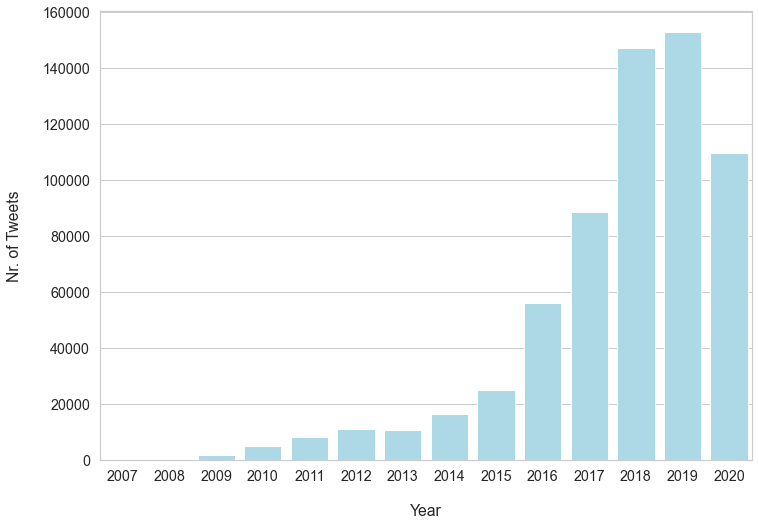

In [7]:
# sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style="whitegrid", font_scale=1.3)

ax = sns.barplot(x=dftemp.index, y=dftemp.values, color="lightblue", saturation=1)
ax.set(xlabel='Year', ylabel='Nr. of Tweets')

ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20

fig = ax.get_figure()
fig.savefig("relevance.png")

# sns.countplot(x="Year", data=dftemp)

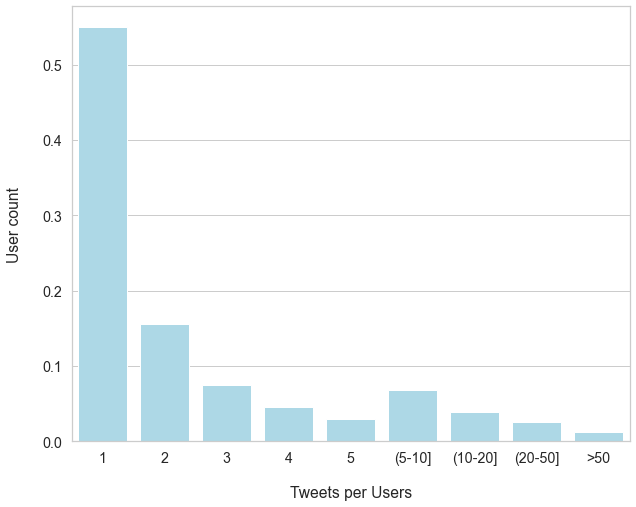

In [8]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set_theme(style="whitegrid", font_scale=1.3)

dfUsersTweets = pd.DataFrame({'Tweets per Users':['1','2','3','4','5','(5-10]','(10-20]', '(20-50]', '>50'], 'User count': [62894, 17865, 8464, 5176, 3432, 7778, 4369, 2871, 1474]})
dfUsersTweets['User count'] = dfUsersTweets['User count'].div(dfUsersTweets['User count'].sum())

ax = sns.barplot(data = dfUsersTweets, x='Tweets per Users', y='User count', color="lightblue", saturation=1)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
# bins = list(range(1, 10))
# ax2 = sns.displot(nrtweetsByUser2, bins=bins, cumulative=True)
# ax2.set(xlabel='Nr. of Users', ylabel='Count')
# ax2.xaxis.labelpad = 20

#sns.displot(nrtweetsByUser2[0:100], kind="ecdf")
# plt.hist(nrtweetsByUser2, bins=[0, 1, 2, 3, 4, 5, 6,7,8,9,10])
fig = ax.get_figure()
# fig.savefig("tweets_per_users.png")


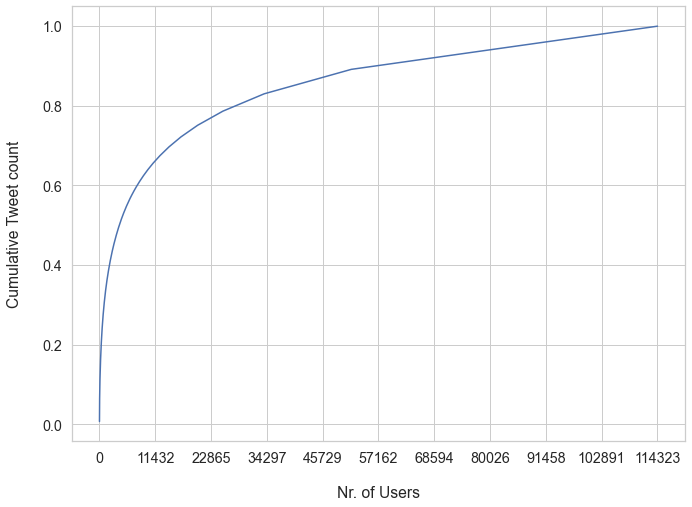

In [13]:
sns.set(rc={'figure.figsize':(11,8)})
sns.set_theme(style="whitegrid", font_scale=1.3)
cumsum = np.cumsum(np.array(nrtweetsByUser2))
cumsum_norm = cumsum / 578480

ticks = (np.arange(0, 114324, step=11432.3))
ax3 = sns.lineplot(data = cumsum_norm)
ax3.set_xticks(ticks)
ax3.set(xlabel='Nr. of Users', ylabel='Cumulative Tweet count')
# ax2.set_xticklabels(['2011','2012','2013','2014','2015','2016','2017','2018'])
ax3.xaxis.labelpad = 20
ax3.yaxis.labelpad = 20

fig = ax3.get_figure()
# fig.savefig("cumulative_tweet_count.png")

## Compare Data from Studie to data set

In [ ]:
# conn = sqlite3.connect("AllTweets_Backup.db")
# c = conn.cursor()

# with open("userBST.txt") as file_in:
#     lines = []
#     for line in file_in:
#         lines.append(line.strip())
        
# # print(set([x for x in lines if lines.count(x) > 1]))

# # print(len(lines))

# array = np.array(lines)
# array = np.unique(array)

# print("Total nr. of users: ", len(array))
# print("Dublicates: ", len(lines) - len(array))
# totalTweets = 0
# usersNotInDB = 0
# tweet_countAllUsers = 0
# with conn:
#     for a in array:
#         nrtweets = c.execute("""Select count(tweet_id), tweet_count  from Tweet, 
#         (SELECT user_id, tweet_count FROM User WHERE user.username = "%s")
#         WHERE user_id = Tweet.author_id""" %a).fetchone()
#         totalTweets += nrtweets[0]
# #         print(nrtweets[0])
#         if nrtweets[0] == 0:
# #             print(a)
#             usersNotInDB += 1
#         if nrtweets[1]:
#             # rate limit for standard api for timeline
#             if nrtweets[1] < 3200:
#                 tweet_countAllUsers += nrtweets[1]
#             else:
#                 tweet_countAllUsers += 3200
            
# print("Total nr. of tweets from these users:", totalTweets)
# print("Total nr. of users not in data set ", usersNotInDB)
# print("tweet_countAllUsers ", tweet_countAllUsers)
        

 # Analyze Sentiment

In [14]:
conn2 = sqlite3.connect("Tweet_Sentiment.db")
c2 = conn.cursor()

In [15]:
df1 = pd.read_sql_query("SELECT * FROM data", conn2)
df2 = pd.read_sql_query("SELECT tweet_id, created_at FROM Tweet WHERE created_at > '2007-12'", conn)

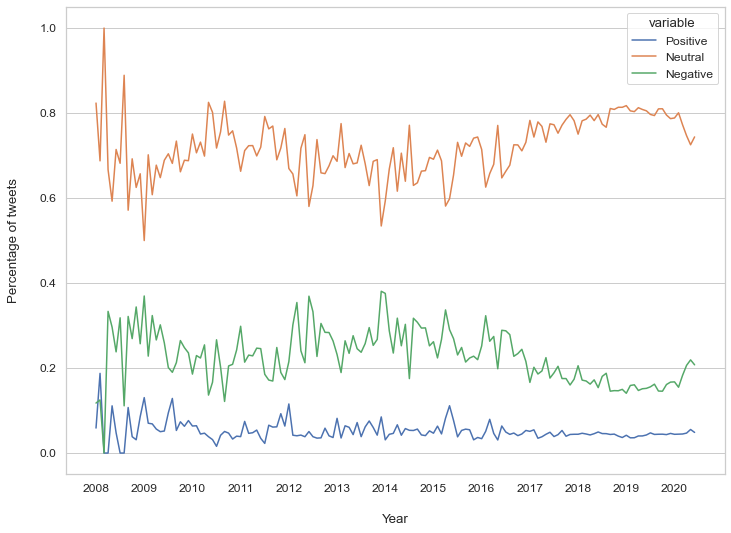

In [16]:
df = pd.merge(df1, df2, how="inner", on="tweet_id").drop("tweet_id", axis=1)
df['created_at'] = df['created_at'].str.split('T', 0, expand=True)
df.created_at = pd.to_datetime(df.created_at)
df = df.set_index("created_at")

sentiment = []

for i in range(0,150):
    date = datetime.datetime(2008, 1, 1) + pd.DateOffset(months=i)
    dftmp = df[date.strftime("%Y-%m")]
    positive = dftmp[dftmp['sentiment'] == 'positive'].shape[0]/dftmp.shape[0]
    neutral = dftmp[dftmp['sentiment'] == 'neutral'].shape[0]/dftmp.shape[0]
    negative = dftmp[dftmp['sentiment'] == 'negative'].shape[0]/dftmp.shape[0]
    
    sentiment.append([date.strftime("%Y-%m"), positive, neutral, negative])

    
    
df_sentiment = pd.DataFrame(sentiment, columns=["Date", "Positive", "Neutral", "Negative"])
# df_sentiment.head

sns.set(rc={'figure.figsize':(11.8,8.6)})
sns.set_theme(style="whitegrid", font_scale=1.1)

ax = sns.lineplot(x='Date', y='value', hue='variable', data=pd.melt(df_sentiment, ['Date']))
ax.set(xlabel='Year', ylabel='Percentage of tweets')
ax.set_xticks(range(len(df_sentiment)))
ax.grid(b=False, axis='x', which='major')


ticklabels = []
count = 8
for i in range(len(df_sentiment)):
    if i % 12 == 0:
        if count > 9:
            ticklabels.append("20%s" %count)
        else:
            ticklabels.append("200%s" %count)
        count+=1
    else:
        ticklabels.append("")

labels = ax.set_xticklabels(ticklabels)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20

# fig = ax.get_figure()
# fig.savefig("sentiment_over_time_monthly.png")



In [ ]:
df = pd.merge(df1, df2, how="inner", on="tweet_id").drop("tweet_id", axis=1)
df['created_at'] = df['created_at'].str.split('T', 0, expand=True)
df.created_at = pd.to_datetime(df.created_at)
df = df.set_index("created_at")

sentiment = []

for i in range(0,13):
    date = datetime.datetime(2008, 1, 1) + pd.DateOffset(years=i)
    dftmp = df[date.strftime("%Y")]
    positive = dftmp[dftmp['sentiment'] == 'positive'].shape[0]/dftmp.shape[0]
    neutral = dftmp[dftmp['sentiment'] == 'neutral'].shape[0]/dftmp.shape[0]
    negative = dftmp[dftmp['sentiment'] == 'negative'].shape[0]/dftmp.shape[0]
    
    sentiment.append([date.strftime("%Y-%m"), positive, neutral, negative])

    
    
df_sentiment = pd.DataFrame(sentiment, columns=["Date", "Positive", "Neutral", "Negative"])
# df_sentiment.head

sns.set(rc={'figure.figsize':(11.8,8.6)})
sns.set_theme(style="whitegrid", font_scale=1.1)

ax = sns.lineplot(x='Date', y='value', hue='variable', data=pd.melt(df_sentiment, ['Date']))
ax.set(xlabel='Year', ylabel='Percentage of tweets')
ax.set_xticks(range(len(df_sentiment)))
ax.grid(b=False, axis='x', which='major')

labels = ax.set_xticklabels(["2008", "2009","2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"])

ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20

# fig = ax.get_figure()
# fig.savefig("sentiment_over_time_yearly.png")



In [ ]:
# conn2 = sqlite3.connect("Tweet_Sentiment.db")
# c2 = conn.cursor()

# df1 = pd.read_sql_query("SELECT * FROM data WHERE sentiment = 'negative' LIMIT 100", conn2)
# df2 = pd.read_sql_query("SELECT tweet_id, tweet_text FROM Tweet", conn)
# df = pd.merge(df1, df2, how="inner", on="tweet_id").drop("tweet_id", axis=1)
# for index, row in df.iterrows():
#     print(row['tweet_text'].replace("\n",""), row['sentiment'])
#     print("\n\n")